<a href="https://colab.research.google.com/github/AbelKristanto/machine-learning/blob/main/class_8_ml_marketing_analysis_using_SPARK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this part, we will to use Pyspark for bank marketing analysis. Let's start!

In [ ]:
# Install pyspark first
!pip install pyspark

In [3]:
# Call the dataset using Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('marketinganalysis')\
                            .getOrCreate()
df = spark.read.csv('bank.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [4]:
df.show(5, False)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job       |marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |admin.    |married|secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician|married|secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |services  |married|secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |admin.    |married|tertiary |no     |184    |no     |no  |unknown|5  |m

In [5]:
# Check number classes
df.groupby('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [6]:
# Summary statistics for numeric variables
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|               day|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|15.658036194230425|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev|11.913369192215518| 3225.413325946149| 8.420739541006462|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                18|             -6847|                 1|                 2|                 1|                -1|                 0|

In [7]:
# Select data
df = df.select('age', 'job', 'marital', 'education', 'default', 
               'balance', 'housing', 'loan', 'contact', 'duration', 
               'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [8]:
# Preparing data for machine learning
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
# a feature transformer that merges multiple columns into a vector column.

# Handling Categorical
cat = ['job', 'marital', 'education', 'default', 
       'housing', 'loan', 'contact', 'poutcome']
stages = []

# Encode Categorical
for categorical in cat:
  strIndexer = StringIndexer(inputCol = categorical, 
                             outputCol = categorical + 'Index')
  encoder = OneHotEncoder(inputCols = [strIndexer.getOutputCol()], 
                          outputCols=[categorical + "classVec"])
  stages += [strIndexer, encoder]

label_strIdx = StringIndexer(inputCol='deposit', outputCol='label')
stages += [label_strIdx]

# Handling Numerical
num = ['age', 'balance', 'duration', 'campaign', 
       'pdays', 'previous']
assemblerInputs = [c+"classVec" for c in cat] + num
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages += [assembler]

#########################################################################
# It indexes each categorical column using the StringIndexer,           #
# then converts the indexed categories into one-hot encoded variables.  #

In [9]:
# PIPELINE
# To chain multiple Transformers and Estimators together.
# To specify our machine learning workflow. 
# A Pipeline’s stages are specified as an ordered array.
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectCols = ['label','features'] + cols
df = df.select(selectCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [12]:
df.show(5, False)


+-----+--------------------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|label|features                                                                                                |age|job       |marital|education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------------------------------------------------------------------------------------------+---+----------+-------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|1.0  |(30,[3,11,13,16,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,2343.0,1042.0,1.0,-1.0])     |59 |admin.    |married|secondary|no     |2343   |yes    |no  |unknown|1042    |1       |-1   |0       |unknown |yes    |
|1.0  |(30,[3,11,13,16,17,18,20,21,24,25,26,27,28],[1.0,1.0,1.0,1.0,

In [11]:
# Take 5 row to show
df.take(5)

[Row(label=1.0, features=SparseVector(30, {3: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 59.0, 25: 2343.0, 26: 1042.0, 27: 1.0, 28: -1.0}), age=59, job='admin.', marital='married', education='secondary', default='no', balance=2343, housing='yes', loan='no', contact='unknown', duration=1042, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes'),
 Row(label=1.0, features=SparseVector(30, {3: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 56.0, 25: 45.0, 26: 1467.0, 27: 1.0, 28: -1.0}), age=56, job='admin.', marital='married', education='secondary', default='no', balance=45, housing='no', loan='no', contact='unknown', duration=1467, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes'),
 Row(label=1.0, features=SparseVector(30, {2: 1.0, 11: 1.0, 13: 1.0, 16: 1.0, 18: 1.0, 20: 1.0, 21: 1.0, 24: 41.0, 25: 1270.0, 26: 1389.0, 27: 1.0, 28: -1.0}), age=41, job='technician', marital='married', education='secondary', defa

In [13]:
# Split dataset into training and testing
train, test = df.randomSplit([0.7,0.3], seed=54)
print("Training dataset: " + str(train.count()))
print("Testing dataset: " + str(test.count()))

Training dataset: 7814
Testing dataset: 3348


## Regression Modelling

In [15]:
# Modelling step
# Logistic Regression Model
from pyspark.ml.classification import LogisticRegression

logreg = LogisticRegression(featuresCol='features', 
                            labelCol = 'label', 
                            maxIter=25)
lr = logreg.fit(train)

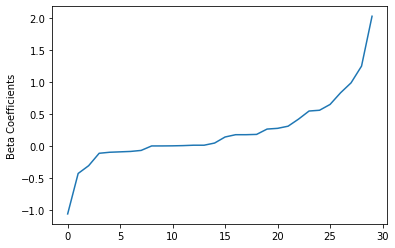

In [16]:
# CREATE EVALUATION
# Coefficients
import matplotlib.pyplot as plt
import numpy as np

betaCoef = np.sort(lr.coefficients)

plt.plot(betaCoef)
plt.ylabel('Beta Coefficients')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


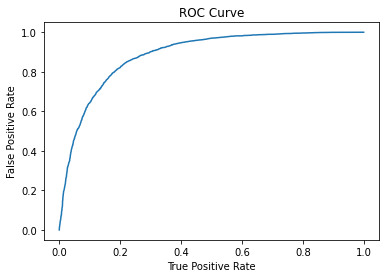

Training set area Under ROC: 0.8865351295157234


In [18]:
# ROC Curve
trainingSummary = lr.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set area Under ROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


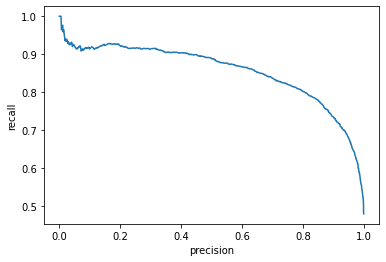

In [21]:
# Precision and Recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.xlabel('precision')
plt.ylabel('recall')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


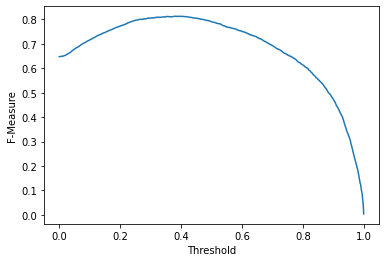

In [23]:
# Threshold to maximaze F-measure
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'], f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [25]:
# PREDICTION
y_pred = lr.transform(test)
y_pred.select('age', 'job', 'label', 
              'rawPrediction', 'prediction',
              'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 34|management|  0.0|[0.29307471186203...|       0.0|[0.57274870611483...|
| 46|management|  0.0|[-0.9355954088204...|       1.0|[0.28179090747191...|
| 52|management|  0.0|[1.31829716686192...|       0.0|[0.78889825995427...|
| 57|management|  0.0|[0.97941074128833...|       0.0|[0.72699127888684...|
| 58|management|  0.0|[2.37541376228641...|       0.0|[0.91493316383528...|
| 61|management|  0.0|[0.69503508123938...|       0.0|[0.66708606806172...|
| 32|management|  0.0|[1.21288934009936...|       0.0|[0.77080978517558...|
| 40|management|  0.0|[1.53649496432900...|       0.0|[0.82295461836796...|
| 46|management|  0.0|[0.23509551833160...|       0.0|[0.55850466521291...|
| 50|management|  0.0|[-0.8835474724539...|       1.0|[0.29244319518820...|
+---+-------

In [27]:
# EVALUATE the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print(evaluator.getMetricName())
print('Test Area Under ROC', evaluator.evaluate(y_pred))

areaUnderROC
Test Area Under ROC 0.8878531972607983


## CV dan Tuning

In [28]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()\
             .addGrid(logreg.regParam, [0.01, 0.5, 2.0])\
             .addGrid(logreg.elasticNetParam, [0.0, 0.5, 1.0])\
             .addGrid(logreg.maxIter, [1, 5, 10])\
             .build())

cv = CrossValidator(estimator=logreg, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
y_pred = cvModel.transform(test)
print(evaluator.getMetricName())
print('Test Area Under ROC', evaluator.evaluate(y_pred))

areaUnderROC
Test Area Under ROC 0.888572340059809


## Decision Tree

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features',
                            labelCol='label', maxDepth=5)
dtModel = dt.fit(train)
y_pred = dtModel.transform(test)
y_pred.select('age', 'job', 
              'label', 'rawPrediction', 
              'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 34|management|  0.0| [378.0,690.0]|       1.0|[0.35393258426966...|
| 46|management|  0.0|[401.0,1796.0]|       1.0|[0.18252162039144...|
| 52|management|  0.0|[1318.0,101.0]|       0.0|[0.92882311486962...|
| 57|management|  0.0| [455.0,232.0]|       0.0|[0.66229985443959...|
| 58|management|  0.0|[1318.0,101.0]|       0.0|[0.92882311486962...|
| 61|management|  0.0| [455.0,232.0]|       0.0|[0.66229985443959...|
| 32|management|  0.0| [455.0,232.0]|       0.0|[0.66229985443959...|
| 40|management|  0.0|  [346.0,14.0]|       0.0|[0.96111111111111...|
| 46|management|  0.0|[401.0,1796.0]|       1.0|[0.18252162039144...|
| 50|management|  0.0| [378.0,690.0]|       1.0|[0.35393258426966...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [30]:
# EVALUATE model
evaluator = BinaryClassificationEvaluator()
print(evaluator.getMetricName())
print('Test Area Under ROC', str(evaluator.evaluate(y_pred, {evaluator.metricName: "areaUnderROC"})))

areaUnderROC
Test Area Under ROC 0.8073763094122658


## Random Forest

In [32]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rfModel = rf.fit(train)
y_pred = rfModel.transform(test)
y_pred.select('age', 'job', 'label', 'rawPrediction',
              'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 34|management|  0.0|[11.7253568129978...|       0.0|[0.58626784064989...|
| 46|management|  0.0|[7.03534259451337...|       1.0|[0.35176712972566...|
| 52|management|  0.0|[13.9729502059052...|       0.0|[0.69864751029526...|
| 57|management|  0.0|[13.9729502059052...|       0.0|[0.69864751029526...|
| 58|management|  0.0|[14.6963524582330...|       0.0|[0.73481762291165...|
| 61|management|  0.0|[7.68475942765574...|       1.0|[0.38423797138278...|
| 32|management|  0.0|[14.6205205587011...|       0.0|[0.73102602793505...|
| 40|management|  0.0|[16.4429902940830...|       0.0|[0.82214951470415...|
| 46|management|  0.0|[9.82237454009093...|       1.0|[0.49111872700454...|
| 50|management|  0.0|[5.15575647146125...|       1.0|[0.25778782357306...|
+---+-------

In [33]:
# EVALUATE model
evaluator = BinaryClassificationEvaluator()
print(evaluator.getMetricName())
print('Test Area Under ROC', str(evaluator.evaluate(y_pred, {evaluator.metricName: "areaUnderROC"})))

areaUnderROC
Test Area Under ROC 0.8839233904783907


In [34]:
# CHECK RF Params, why is so high?
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

## Gradient Boosting Tree

In [35]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
y_pred = gbtModel.transform(test)
y_pred.select('age', 'job', 'label', 'rawPrediction',
              'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 34|management|  0.0|[-0.1156165792319...|       1.0|[0.44244791875210...|
| 46|management|  0.0|[-0.5950936389055...|       1.0|[0.23322544295711...|
| 52|management|  0.0|[1.01031270336071...|       0.0|[0.88294566202945...|
| 57|management|  0.0|[0.56848905457566...|       0.0|[0.75712438426353...|
| 58|management|  0.0|[1.16919404925514...|       0.0|[0.91200681533493...|
| 61|management|  0.0|[-0.3611999937235...|       1.0|[0.32686470842786...|
| 32|management|  0.0|[0.74438223786413...|       0.0|[0.81589275472578...|
| 40|management|  0.0|[1.26671061788815...|       0.0|[0.92645181286120...|
| 46|management|  0.0|[0.12553925556055...|       0.0|[0.56244194140566...|
| 50|management|  0.0|[-0.5863535768333...|       1.0|[0.23636600215913...|
+---+-------

In [36]:
# EVALUATE model
evaluator = BinaryClassificationEvaluator()
print(evaluator.getMetricName())
print('Test Area Under ROC', str(evaluator.evaluate(y_pred, {evaluator.metricName: "areaUnderROC"})))

areaUnderROC
Test Area Under ROC 0.892608726388773


In [37]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [38]:
# TUNING

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()\
             .addGrid(gbt.maxDepth, [2,5,6])\
             .addGrid(gbt.maxBins, [20, 50,60])\
             .addGrid(gbt.maxIter, [10,20,30])\
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)

# RUN CROSS Validations
cvModel = cv.fit(train)
y_pred = cvModel.transform(test)
evaluator.evaluate(y_pred)

0.8965152076811904

Finally, we chosen GBT for the model